# Imports

In [136]:
import os

import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from dotenv import load_dotenv, find_dotenv
from openai import OpenAI

import utility.utility as util
import utility.prompts as prompts

# Progress Bars:
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

# Below import and instructions simply for display
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# resets import once changes have been applied
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Directory and File Paths

In [60]:
path_data = os.path.join(os.getcwd(), "data")

path_stmts = os.path.join(path_data, "predict")

file_excel = os.path.join(path_data, "examples_altered.xlsx")

# Load Environment Variables

In [61]:
_ = load_dotenv(find_dotenv())

# Load Data

In [62]:
df_meta = pd.read_excel(file_excel, sheet_name="Sheet1")

# Preliminary Adjustments

In [63]:
df_meta.dropna(axis=1, inplace=True, thresh = int(df_meta.shape[0]*.1))
df_meta.drop(columns=["checked by", "new", "manual", "page (txt)", "manual", "note"], inplace=True)
df_meta["filename"] = df_meta["filename"].astype("str") + ".txt"
df_meta["filepath"] = df_meta["filename"].apply(lambda x: os.path.join(path_stmts, x))

# Split "Train" "Test"

In [64]:
prompt_indeces = [0,1,2,3,4,5,6,7,16,17,20,21,26,27,34,35,36,37]
test_indeces = [i for i in df_meta.index if i not in prompt_indeces]

In [65]:
prompt_df = df_meta.iloc[prompt_indeces,:].copy()
test_df = df_meta.iloc[test_indeces,:].copy()
del df_meta

# Extract most common terms:

In [66]:
min_ratio = .5

terms_auditor = util.concat_terms(util.det_commonly_used_terms(prompt_df["terms_audit"], min_ratio=min_ratio), ", ")
terms_notes = util.concat_terms(util.det_commonly_used_terms(prompt_df["terms_notes"], min_ratio=min_ratio), ", ")
#terms_acc_stds = util.concat_terms(util.det_commonly_used_terms(df_meta["term"], min_ratio=0), " - ")

section_terms_auditor = prompts.common_terms_section_auditor.format(terms_auditor = terms_auditor)
section_terms_notes = prompts.common_terms_section_notes.format(terms_notes = terms_notes)
#section_terms_acc_stds = prompts.common_terms_accounting_stds.format(acc_std = terms_acc_stds)

# Construct Base Prompt

## System Context

In [67]:
system = prompts.system_context_basic + \
         prompts.task_descr_1 + \
         section_terms_auditor + \
         section_terms_notes + \
         prompts.instruction_1 + \
         prompts.answer_format1

### User_Assitant Context - examples in conversations user-assistant

In [68]:
user_assistant = util.get_user_assistant_context_format1(prompt_df, "filename", "source", "paragraph (context)", "sentence", "term")

# Examples in one prompt

In [69]:
prompt_examples = util.get_examples_prompt(prompts.examples_base1, prompt_df, "filename", "source", "paragraph (context)", "sentence", "term")
system += prompt_examples

In [75]:
print(util.count_tokens(system))
print(system)

5022

You are a financial accountant.

You are tasked to extract information contained within two sections, the auditor section and the notes section,  of a provided financial statement. More specifically, from the notes section you are tasked to extract according to what accounting standard the financial statement has been prepared, and from the auditor section you are tasked to extract what accounting standard the financial statement is in compliance with. It is possible that a financial statement is in compliance with or has been constructed according to multiple standards, in which case you should extract both - note, double standards are most likely in close vicinity to each other. I will provide you with long textual sequences. Make absolutely sure that you only respond with phrases you find within the provided financial statement. Before providing an answer, check whether you can find it within the provided text.


For the auditor part you will most likely find some of these ter

# Extract Text Prompt

In [149]:
util.segment_text_column(df_inputs, "filename", "prompt", 12000, 200)

,filepath,filename,cc_iso3,prompt,num_tokens,com_num_tokens,segment
0,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61466756.txt,SGP,CEI Contract Manufacturing Limited Company Reg...,12000,36931,0
1,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61466756.txt,SGP,is not be remeasured until it is finally sett...,12000,36931,1
2,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61466756.txt,SGP,in force (unless such compliance has been wai...,8309,36931,2
3,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61511488.txt,SGP,"Transcending Boundaries, Growing Opportunities...",12000,43471,0
4,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61511488.txt,SGP,individual performance while the remuneration...,12000,43471,1
...,...,...,...,...,...,...,...
58,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,60783048.txt,FRA,Group Terms and conditions: The taxable incom...,12000,87780,5
59,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,60783048.txt,FRA,approves the consolidated financial statement...,11958,87780,6
60,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61015098.txt,GBR,ANNUAL REPORT & ACCOUNTS AVESCO GROUP PLC ANNU...,12000,38881,0
61,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61015098.txt,GBR,"and Mr Nicholson, who were appointed to the B...",12000,38881,1


In [81]:
df_inputs

,filepath,filename,cc_iso3,prompt,num_tokens,com_num_tokens
8,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61466756.txt,SGP,CEI Contract Manufacturing Limited Company Reg...,31909,36931
10,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61511488.txt,SGP,"Transcending Boundaries, Growing Opportunities...",38449,43471
12,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,62075442.txt,PHL,I I I I I SEC Rogi·tration Numbu I AIcI EIs I ...,69601,74623
14,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,62609130.txt,TUR,"CONTENTS TURCAS IN BRIEF Vision, Mission, Stra...",53216,58238
18,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,64866413.txt,IND,SUMMIT SECURITIES LIMITED Corporate Identifica...,54653,59675
22,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,172416837.txt,CAN,RITCHIE BROS AUCTIONEERS INC Form -K Filed on ...,163019,168041
24,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,60665866.txt,CHL,Endesa Chile annual report cifras de negocios ...,94232,99254
28,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,60816306.txt,AUS,Annual Report Brambles Brambles Annual Report ...,87561,92583
30,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,60783048.txt,FRA,Reference Document Financial year ending This ...,82758,87780
32,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61015098.txt,GBR,ANNUAL REPORT & ACCOUNTS AVESCO GROUP PLC ANNU...,33859,38881


In [71]:
df_inputs = test_df[['filepath', 'filename','cc_iso3']].copy().drop_duplicates()
df_inputs['prompt'] = df_inputs['filepath'].apply(util.parse_txt).apply(util.clean_text)

In [72]:
df_inputs['num_tokens'] = df_inputs['prompt'].apply(util.count_tokens)
base_prompt_length = util.count_tokens(system)
df_inputs['com_num_tokens'] = df_inputs['num_tokens'] + base_prompt_length

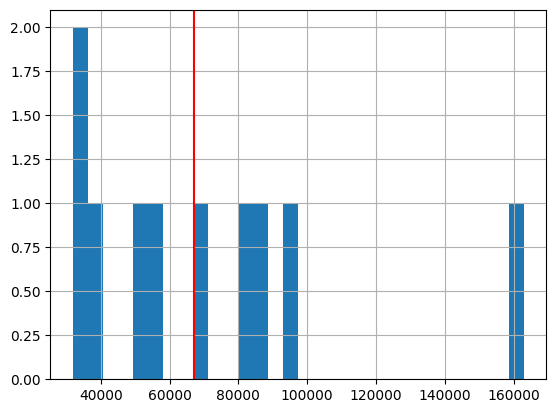

In [73]:
df_inputs['num_tokens'].hist(bins=30)
plt.axvline(x=df_inputs['com_num_tokens'].median(), color = "r")

# reduce to below 60k tokens

In [28]:
df_inputs = df_inputs[df_inputs.num_tokens <= 60000]

In [29]:
df_inputs['com_num_tokens']

8     36931
10    43471
14    58238
18    59675
32    38881
Name: com_num_tokens, dtype: int64

In [30]:
df_inputs['com_num_tokens'].cumsum()

8      36931
10     80402
14    138640
18    198315
32    237196
Name: com_num_tokens, dtype: int64

# Calculate Cost

In [31]:
util.calc_price_gpt(df_inputs.shape[0], df_inputs.com_num_tokens.mean(), 1, .01, 1000)

2.37196

In [58]:
util.calc_price_gpt(100_000, 16_000, 3, .0005, 1_000)

{'$ (excl. VAT)': 2400.0}

In [57]:
util.calc_compute_time(100_000, 16000, 3, 160_000)

{'days': 20.0, 'hours': 20.0, 'min': 0.0, 'raw min': 30000.0}

# Prompt GPT

## Initialize Client

In [33]:
client = OpenAI()

## Call API

In [34]:
df_inputs['output'] = df_inputs.progress_apply(lambda x: util.prompt_gpt(client, system, x.prompt, user_assistant, "gpt-4-0125-preview"), axis=1)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-05 23:22:59.255360
2024-03-05 23:23:08.327833
2024-03-05 23:23:51.294144
2024-03-05 23:24:15.871878
2024-03-05 23:24:47.794655


# Evaluation

In [35]:
df_inputs

,filepath,filename,cc_iso3,prompt,num_tokens,com_num_tokens,output
8,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61466756.txt,SGP,CEI Contract Manufacturing Limited Company Reg...,31909,36931,ChatCompletion(id='chatcmpl-8zXTYxcEDFKwZ1mK72...
10,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61511488.txt,SGP,"Transcending Boundaries, Growing Opportunities...",38449,43471,ChatCompletion(id='chatcmpl-8zXThvxa4tpz7KeiFz...
14,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,62609130.txt,TUR,"CONTENTS TURCAS IN BRIEF Vision, Mission, Stra...",53216,58238,ChatCompletion(id='chatcmpl-8zXUOsQtpDseealpdl...
18,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,64866413.txt,IND,SUMMIT SECURITIES LIMITED Corporate Identifica...,54653,59675,ChatCompletion(id='chatcmpl-8zXUnVGu6GAXf64uhS...
32,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61015098.txt,GBR,ANNUAL REPORT & ACCOUNTS AVESCO GROUP PLC ANNU...,33859,38881,ChatCompletion(id='chatcmpl-8zXVJZfxFZK5urc4OR...


In [41]:
df_inputs['prompt'].values[-1]

'ANNUAL REPORT & ACCOUNTS AVESCO GROUP PLC ANNUAL REPORT CONTENTS PROFILE HIGHLIGHTS CHAIRMAN\'S STATEMENT REVIEW OF OPERATIONS FINANCIAL REVIEW BOARD OF DIRECTORS ADVISORS DIRECTORS\' REPORT DIRECTORS\' REMUNERATION REPORT CORPORATE GOVERNANCE REPORT STATEMENT OF DIRECTORS\' RESPONSIBILITIES INDEPENDENT AUDITORS\' REPORT ACCOUNTS AND NOTES NOTICE OF MEETING FORM OF PROXY PRINCIPAL OFFICES IBC THE AVESCO GROUP UK MAINLAND EUROPE NORTH AMERICA MIDDLE EAST ASIA CREATIVE TECHNOLOGY Major events & award ceremonies CT London CT Germany CT North America CT Dubai CT Shanghai FULL SERVICE From dry hire to large events MCL Action JVR BROADCAST SERVICES Broadcast equipment, systems & services to the broadcast market Presteigne Fountain Studios Presteigne AVESCO GROUP PLC ANNUAL REPORT PROFILE MAKING EVERYDAY EVENTS WORLD CLASS Avesco Group plc is the parent company of an international media services group providing services to the corporate presentation, entertainment and broadcast markets by br

In [24]:
for row in df_inputs.index:
    print(df_inputs.loc[row].filename, df_inputs.loc[row]["output"].choices[0].message.content)
    print()

61466756.txt {
'Notes' : {
    'sentence' : "The financial statements have been prepared in accordance with Singapore Financial Reporting Standards (\"FRS\")",
    'standard' : "Singapore Financial Reporting Standards (\"FRS\")"},
'Auditor' : {
    'sentence' : "In our opinion, the consolidated financial statements of the Group and the balance sheet and statement of changes in equity of the Company are properly drawn up in accordance with the provisions of the Act and Singapore Financial Reporting Standards so as to give a true and fair view of the state of affairs of the Group and of the Company as at 31 December 2010 and the results, changes in equity and cash flows of the Group and the changes in equity of the Company for the year ended on that date.",
    'standard' : "Singapore Financial Reporting Standards"}
}

61511488.txt {
  "Notes": {
    "sentence": "The consolidated financial statements of the Group have been prepared in accordance with Singapore Financial Reporting Standar

In [36]:
files = df_inputs.filename.values
labels = test_df[test_df.filename.isin(files)]

In [37]:
labels['cc_iso3 filename sentence term source'.split()]

,cc_iso3,filename,sentence,term,source
8,SGP,61466756.txt,"In our opinion, the the consolidated financial...",Singapore Financial Reporting Standards,audit
9,SGP,61466756.txt,The consolidated financial statements of the ...,Singapore Financial Reporting Standards (“FRS”),notes
10,SGP,61511488.txt,"In our opinion, the financial statements of t...",Singapore Financial Reporting Standards,audit
11,SGP,61511488.txt,The consolidated financial statements of the G...,"Singapore Financial Reporting Standards (""FRS"")",notes
14,TUR,62609130.txt,the consolidated financial statements present ...,Turkish Accounting Standards.,audit
15,TUR,62609130.txt,The accompanying consolidated financial statem...,Turkish Accounting Standards,notes
18,IND,64866413.txt,These consolidated financial statements have b...,Generally Accepted Accounting \nPrinciples in ...,notes
19,IND,64866413.txt,the aforesaid \nstandalone financial statement...,accounting principles generally \naccepted in ...,audit
32,GBR,61015098.txt,These financial statements have been prepared ...,United Kingdom accounting standards,notes
33,GBR,61015098.txt,the financial statements give a true and fair ...,United Kingdom Generally Accepted Accounting P...,audit
